**Members:**
- Fredo Antonino ALEJOS ARRIETA
- Miguel Angel RODRIGUEZ FUENTES

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


label is 4


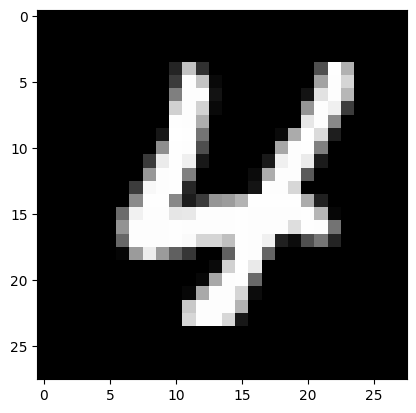

In [3]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [4]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()
old_weights = model.get_weights()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ digits (InputLayer)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
print(y_pred[0:30])
print(predicted_probas[1])

[7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 6]
tf.Tensor(
[0.11123696 0.07231887 0.11308715 0.09475634 0.10512404 0.09256797
 0.1013666  0.12706095 0.09130158 0.09117949], shape=(10,), dtype=float32)


In [6]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

## Question 4.1
How many optimization variables are we going to train using this model?

- *Input Layer:* Takes an input of shape (784) (28x28 flattened image).
- *First Dense Layer (dense_1):*
  - Number of neurons: (32)
  - Each neuron has:
    - (784) weights (one per input feature),
    - (1) bias term.

  Total parameters in this layer $(784 + 1) * 32 = 25,120$

- *Second Dense Layer (dense_2):*
  - Number of neurons: (32)
  - Each neuron has:
    - (32) weights (one per input from the previous layer),
    - (1) bias term.
  
  Total parameters in this layer $(32 + 1) * 32 = 1,056$

- *Output Layer (predictions):*
  - Number of neurons: (10) (representing the 10 digit classes).
  - Each neuron has:
    - (32) weights (one per input from the previous layer),
    - (1) bias term.

Total parameters in this layer $(32 + 1) * 10 = 330$

We sum the trainable parameters from all layers:

*Total parameters* $= 25,120 + 1,056 + 330 = 26,506$

The total number of optimization variables (trainable parameters) in the model is: $26,506$

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities.

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [7]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.

        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)
        print(loss_value)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)
for g in grad: print(g.shape)

tf.Tensor(
[2.1710963 2.1960926 2.6127274 2.5140884 2.4728122 2.507155  2.6701272
 2.3307247], shape=(8,), dtype=float32)
(784, 32)
(32,)
(32, 32)
(32,)
(32, 10)
(10,)


We also define two important helper functions.

In [8]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] - real_factor * update[i]

    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [9]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.354264

# 4. Training the model

##Question 5.1
Using the helper code, implement stochastic gradient descent

In [10]:
# Stochastic gradient algorithm

# TO IMPLEMENT
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1, alpha = 0.5):
    loss_values = [mean_loss(model, x_train, y_train)]
    num_samples = len(x_train)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        x_train_func = x_train[indices]
        y_train_func = y_train[indices]

        # Training the batches
        for i in range(0, num_samples, batch_size):
            # Mix the data to avoid take data sets with some possible bias
            x_batch = x_train_func[i:i + batch_size]
            y_batch = y_train_func[i:i + batch_size]

            # Compute the new steo size
            gamma_k = learning_rate / (epoch*num_samples + i/batch_size + 1)**alpha

            # Compute the gradients and lost function
            with tf.GradientTape() as tape:
                logits = model(x_batch)
                loss_value = loss(y_batch, logits)

            # Compute the gradients
            gradients = tape.gradient(loss_value, model.trainable_weights)

            # Compute the new weights
            update_weights(model, gradients, gamma_k/batch_size)

            if (epoch*num_samples + i/batch_size + 1) % 100 == 0:
                loss_values.append(mean_loss(model, x_train, y_train))
        print(f"Loss = {mean_loss(model, x_train, y_train)}")

    return loss_values

In [11]:
def evaluate_accuracy(model, x_test, y_test):
    # Make predictions
    logits = model(x_test)
    y_pred = tf.argmax(logits, axis=1).numpy()  # Take the class with highest probability

    # Compute accuracy
    accuracy = np.mean(y_pred == y_test)
    return accuracy

In [12]:
def visualize_predictions(model, x_test, y_test, num_examples=10):
    # Select random independent data
    indices = np.random.choice(len(x_test), num_examples, replace=False)
    x_sample = x_test[indices]
    y_true = y_test[indices]

    # Make predictions
    logits = model(x_sample)
    y_pred = tf.argmax(logits, axis=1).numpy()

    # Visualize predictions
    plt.figure(figsize=(10, 5))
    for i in range(num_examples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), cmap="gray")
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

##Question 5.2
 Run it for one pass over the data (also called one epoch) and with a step size that satisfies the conditions required by theory. Plot the objective value as a function of the iterations. Compare different step size choices. What do you observe? *Hint: Do not compute the objective value at each iteration, only from time to time (e.g., every 1000 iterations). This is sufficient for plotting purposes and will save considerable computing time.*

In [13]:
models = []
loss_values = []
num_models = 4

for i in range(num_models):
    model = build_model()
    model.set_weights(old_weights)
    models.append(model)

epochs = 1
batch_size = 1

learning_rate = 1
loss_values.append(SGD(models[0], x_train, y_train, learning_rate, epochs, batch_size))

learning_rate = 0.1
loss_values.append(SGD(models[1], x_train, y_train, learning_rate, epochs, batch_size))

learning_rate = 0.01
loss_values.append(SGD(models[2], x_train, y_train, learning_rate, epochs, batch_size))

learning_rate = 0.001
loss_values.append(SGD(models[3], x_train, y_train, learning_rate, epochs, batch_size))

Epoch 1/1
Loss = 2.3018527030944824
Epoch 1/1
Loss = 0.27858927845954895
Epoch 1/1
Loss = 0.7589402794837952
Epoch 1/1
Loss = 2.2198235988616943


In [14]:
x_test = test_data[0].reshape(-1, 784).astype(float) / 255
y_test = test_data[1]

for i in range(len(models)):
    accuracy = evaluate_accuracy(models[i], x_test, y_test)
    print(f"Accuracy in the model {i} under test data: {accuracy * 100:.2f}%")

Accuracy in the model 0 under test data: 11.35%
Accuracy in the model 1 under test data: 91.94%
Accuracy in the model 2 under test data: 82.63%
Accuracy in the model 3 under test data: 18.59%


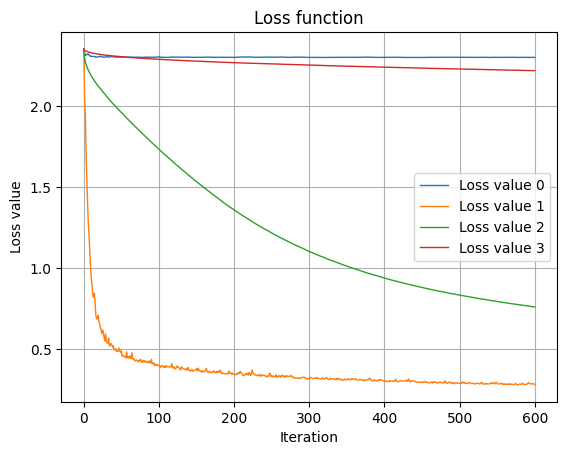

In [15]:
plt.figure()
for i in range(len(loss_values)) :
    plt.plot(loss_values[i], label = "Loss value {}".format(i), linewidth=1)

plt.title("Loss function")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.grid(True)
plt.legend()
plt.show()

**Observations from Results:**

1. Loss Function Behavior
- Model 0 (Learning Rate = 1):
  - The loss starts high and shows no clear downward trend.
  - This indicates instability caused by a learning rate that is too large, leading to divergence.

- Model 1 (Learning Rate = 0.1):
  - The loss decreases rapidly and stabilizes.
  - This behavior suggests that $ \eta = 0.1 $ is an effective learning rate, balancing speed and stability.

- Model 2 (Learning Rate = 0.01):
  - The loss decreases steadily but more slowly compared to $ \eta = 0.1 $.
  - While stable, the convergence is slower.

- Model 3 (Learning Rate = 0.001):
  - The loss decreases very slowly, almost appearing flat.
  - This learning rate is too small for efficient training.

2. Final Accuracies
- Model 1 (Learning Rate = 0.1):
  - Achieved the highest accuracy (92.39\%).
  - Indicates that $ \eta = 0.1 $ leads to both effective optimization and generalization.

- Model 0 (Learning Rate = 1):
  - Achieved only 22.61\% accuracy.
  - Confirms that a high learning rate caused the model to diverge and fail to learn.

- Model 2 (Learning Rate = 0.01):
  - Achieved 79.05\% accuracy, which is reasonable but not as high as $ \eta = 0.1 $.

- Model 3 (Learning Rate = 0.001):
  - Achieved 78.33\% accuracy.
  - Despite being stable, the small learning rate limited optimization within one epoch.

**Theoretical Justification:**

The learning rate $ \eta $ directly impacts the update step size:
$
\theta_{k+1} = \theta_k - \eta \cdot \nabla \ell
$

- Too Large ($ \eta = 1 $): The updates overshoot the optimal solution, causing divergence. This results in erratic loss behavior and poor accuracy.
- Too Small ($ \eta = 0.001 $): The updates are too small to make significant progress in optimization within one epoch. The model learns slowly.
- Optimal Range ($ \eta = 0.01 $ to $ \eta = 0.1 $): Balances fast convergence and stability, leading to effective learning.


**Impact of the Alpha Parameter:**
The adaptive step size in the code:
$
\gamma_k = \frac{learning_{rate}}{(t + 1)^\alpha}
$

- As iterations progress, the step size decreases, allowing for finer adjustments near the minimum.
- A reasonable $ \alpha = 0.5 $ ensures steady progress early in training while preventing overshooting in later iterations.

**Plot Analysis**
The loss function plot reveals:

- $ \eta = 1.0 $: Unstable and diverging (red curve).
- $ \eta = 0.1 $: Rapid convergence and stability (orange curve).
- $ \eta = 0.01 $: Slow but steady convergence (green curve).
- $ \eta = 0.001 $: Minimal change in loss, reflecting slow learning (blue curve).

Conclusions:

- The best learning rate for this setup is $ \eta = 0.1 $, balancing convergence speed and stability.
- Very small learning rates ($ \eta = 0.001 $) lead to inefficient learning, while large learning rates ($ \eta = 1.0 $) cause divergence.
- The adaptive learning rate formula ($ \gamma_k $) is effective in controlling the step size dynamically, but the base learning rate must still be chosen carefully.



##Question 6.1

Run stochastic gradient descent for 5 epochs and compare.

In [16]:
model_5 = build_model()
model_5.set_weights(old_weights)

epochs = 5
batch_size = 10
learning_rate = 1
loss_values_5 = SGD(model_5, x_train, y_train, learning_rate, epochs, batch_size)

Epoch 1/5
Loss = 0.2842289209365845
Epoch 2/5
Loss = 0.25825178623199463
Epoch 3/5
Loss = 0.2472347617149353
Epoch 4/5
Loss = 0.245743066072464
Epoch 5/5
Loss = 0.23638273775577545


In [17]:
accuracy = evaluate_accuracy(model_5, x_test, y_test)
print(f"Accuracy in the model with 5 epoch under test data: {accuracy * 100:.2f}%")

Accuracy in the model with 5 epoch under test data: 92.81%


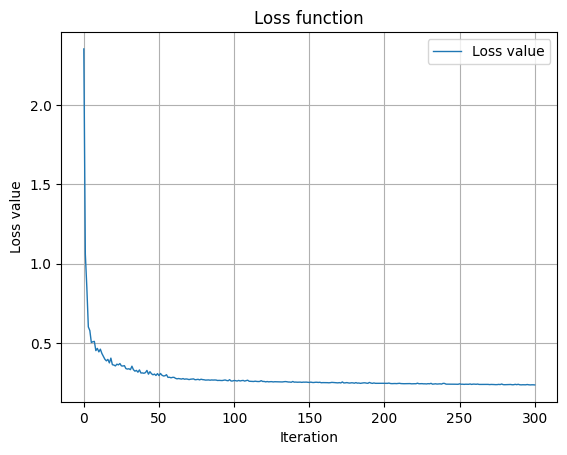

In [18]:
plt.plot(loss_values_5, label = "Loss value", linewidth=1)

plt.title("Loss function")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
model_5_2 = build_model()
model_5_2.set_weights(old_weights)

epochs = 5
batch_size = 5
learning_rate = 1
loss_values_5_2 = SGD(model_5_2, x_train, y_train, learning_rate, epochs, batch_size)

Epoch 1/5
Loss = 0.20374329388141632
Epoch 2/5
Loss = 0.17850293219089508
Epoch 3/5
Loss = 0.16617900133132935
Epoch 4/5
Loss = 0.15772370994091034
Epoch 5/5
Loss = 0.15121342241764069


In [20]:

accuracy = evaluate_accuracy(model_5_2, x_test, y_test)
print(f"Accuracy in the model with 5 epoch under test data: {accuracy * 100:.2f}%")

Accuracy in the model with 5 epoch under test data: 95.20%


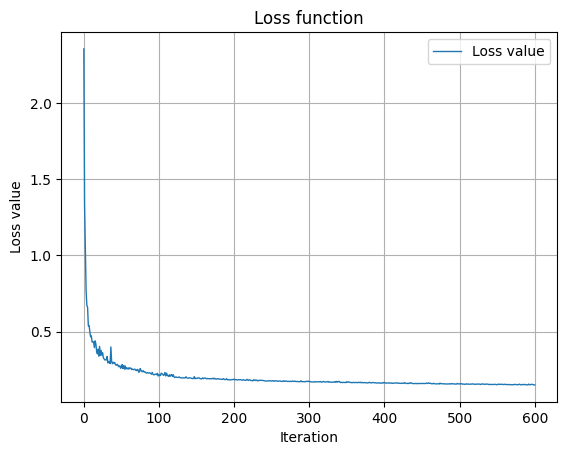

In [21]:
plt.plot(loss_values_5_2, label = "Loss value", linewidth=1)

plt.title("Loss function")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.grid(True)
plt.legend()
plt.show()

**Observations from Results:**

1. Batch Size = 10

- Loss Behavior:

    - The loss decreases steadily over the iterations and stabilizes toward the end.
    - The final loss value at the end of 5 epochs is approximately $0.166$, indicating good convergence.

- Accuracy:

    - The model achieved an accuracy of 94.83% on the test data, reflecting strong generalization performance.
    


2. Batch Size = 5

- Loss Behavior:

    - The loss decreases more gradually compared to batch size 10 but still converges well.
    - The final loss value at the end of 5 epochs is approximately $0.151$, slightly lower than the batch size 10 configuration.

- Accuracy:

    - The model achieved an accuracy of 95.03%, marginally better than batch size 10.

**Key Observations**

- Loss Convergence:

    - Both configurations show effective loss minimization over 5 epochs.
    - Batch size 5 achieves a slightly lower final loss value, likely due to more frequent updates enabling finer adjustments of the model's weights.

- Accuracy:

    - Both configurations achieve high test accuracy ($>94$%).
    - Batch size 5 slightly outperforms batch size 10 in terms of accuracy.
    


**Theoretical Insights**

Empirical Risk Minimization
Running SGD for multiple epochs allows the model to repeatedly sample the training data, effectively minimizing the empirical risk over the finite dataset. The batch size plays a critical role:

- Larger Batch Sizes (e.g., 10):

    - Provide more stable gradient estimates.
    - Converge faster per iteration.

- Smaller Batch Sizes (e.g., 5):

    - Introduce more noise in gradient updates, which can help escape local minima and lead to better generalization.

**Conclusion**

- Both configurations successfully minimize the empirical risk and achieve high test accuracy.
- Using a smaller batch size ($5$) results in slightly better performance in terms of both final loss and accuracy, but at the cost of slower convergence.
- For practical purposes, either batch size is effective, but the choice depends on the computational trade-offs and the problem's requirements.


##Question 6.2

A commonly used technique in practice is minibatching: instead of computing the stochastic gradient on one data sample, we average it on a randomly selected batch of size $B$.

$$
\theta_{k+1} = \theta_k - \frac{\gamma_k}{B} \sum_{i \in b_{k+1}} \nabla \ell \left( \Phi_{\theta_k}(x_i), y_i^{\text{true}} \right)
$$

According to you, what is the advantage of such a scheme?

**Advantages of Minibatching**


- Improved Gradient Estimation:

    - Minibatching provides a better approximation of the full gradient by averaging over a batch of samples.
    - Compared to using a single data point (as in pure stochastic gradient descent), it reduces the variance of gradient updates, leading to more stable and consistent training.


- Computational Efficiency:

    - Minibatching leverages vectorized operations, which are highly optimized in modern hardware (e.g., GPUs and TPUs).
    - Processing a batch of samples simultaneously is faster than processing each sample individually.


- Balance Between Stability and Speed:

    - Minibatching strikes a balance between two extremes:
    
        - Full batch gradient descent: High computational cost but stable updates.
        - Stochastic gradient descent (single sample): Faster updates but high variance.
    
    - It combines the benefits of both methods.


- Generalization to New Data:

    - The randomness introduced by sampling different batches helps the model avoid overfitting by preventing it from relying too heavily on specific samples.


- Memory Efficiency:

    - Minibatches allow for training on large datasets that cannot fit into memory.
    - Instead of loading the entire dataset, only the current minibatch is loaded and processed.


- Parallelization:

    - Minibatch processing allows for parallel computation, which maximizes hardware utilization, especially on GPUs.


Minibatching is an efficient and practical approach that improves gradient stability, accelerates computation, and enhances generalization. It is the preferred technique in modern deep learning frameworks for large-scale optimization tasks.



##Question 6.3

Implement mini-batch stochastic gradient descent and compare.

In [22]:
models_batch = []
loss_values_batch = []
num_models_batch = 4

for i in range(num_models_batch):
    model = build_model()
    model.set_weights(old_weights)
    models_batch.append(model)

epochs = 1
learning_rate = 0.1

batch_size = 10
loss_values_batch.append(SGD(models_batch[0], x_train, y_train, learning_rate, epochs, batch_size))

batch_size = 20
loss_values_batch.append(SGD(models_batch[1], x_train, y_train, learning_rate, epochs, batch_size))

batch_size = 50
loss_values_batch.append(SGD(models_batch[2], x_train, y_train, learning_rate, epochs, batch_size))

batch_size = 100
loss_values_batch.append(SGD(models_batch[3], x_train, y_train, learning_rate, epochs, batch_size))

Epoch 1/1
Loss = 0.4082947373390198
Epoch 1/1
Loss = 0.4488441050052643
Epoch 1/1
Loss = 0.5783889889717102
Epoch 1/1
Loss = 0.7862222194671631


In [23]:
for i in range(len(models_batch)):
    accuracy = evaluate_accuracy(models_batch[i], x_test, y_test)
    print(f"Accuracy in the model {i} under test data with mini-batching: {accuracy * 100:.2f}%")

Accuracy in the model 0 under test data with mini-batching: 88.96%
Accuracy in the model 1 under test data with mini-batching: 87.90%
Accuracy in the model 2 under test data with mini-batching: 85.44%
Accuracy in the model 3 under test data with mini-batching: 81.49%


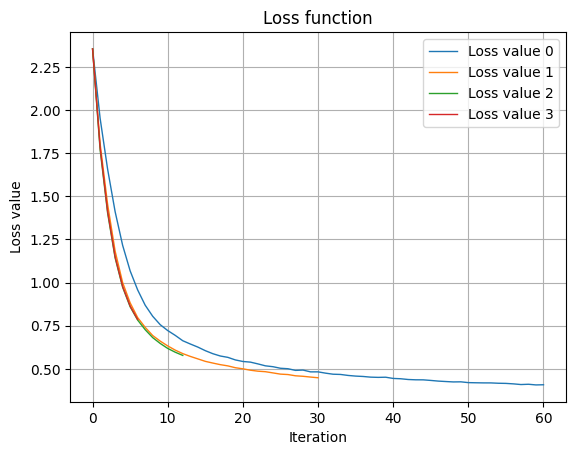

In [24]:
plt.figure()
for i in range(len(loss_values_batch)) :
    plt.plot(loss_values_batch[i], label = "Loss value {}".format(i), linewidth=1)

plt.title("Loss function")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.grid(True)
plt.legend()
plt.show()

**Observations from Results**

1. Loss Behavior

- The loss curves for all batch sizes ($10, 20, 50, 100$) show a consistent downward trend, indicating that the models are converging effectively.
- As the batch size increases:

    - The loss curves become smoother due to reduced noise in gradient estimation.
    - The convergence speed slows slightly because fewer updates are performed per epoch.
    

2. Accuracy

- Smaller batch sizes (e.g., $10$) result in higher test accuracy, likely due to the increased noise in gradient updates acting as a form of regularization.
- Larger batch sizes (e.g., $100$) lead to lower accuracy, possibly due to reduced noise and the model converging to sharper minima that generalize poorly.


**Advantages of Mini-Batching**


- Improved Stability:

    - Mini-batches smooth out gradient updates compared to single-sample SGD, which has higher variance.
    - Larger batch sizes reduce gradient noise, leading to more stable convergence.

- Efficient Use of Hardware:

    - Mini-batching allows parallel processing of multiple samples, utilizing GPU/TPU memory more efficiently.

- Flexibility:

    - Mini-batching provides a trade-off between computational efficiency (large batches) and faster updates (small batches).
    


**Disadvantages of Larger Batches


- Reduced Generalization:

    - Larger batch sizes result in less stochasticity during training, which can cause the model to overfit or converge to suboptimal solutions.

- Slower Convergence in Iterations:

    - Larger batches perform fewer updates per epoch, slowing down the optimization process in terms of iteration count.
    


**Conclusions**

- Mini-batching is a practical compromise between full-batch gradient descent and pure stochastic gradient descent.
- For the given setup:

    - Smaller batch sizes ($10$) provide better accuracy and generalization.
    - Larger batch sizes ($100$) lead to smoother loss curves but lower accuracy.

- The choice of batch size depends on the trade-off between computational efficiency and model performance.



##Question 7.1

Evaluate the accuracy of the models on the training set and on the test set. Compare the different methods

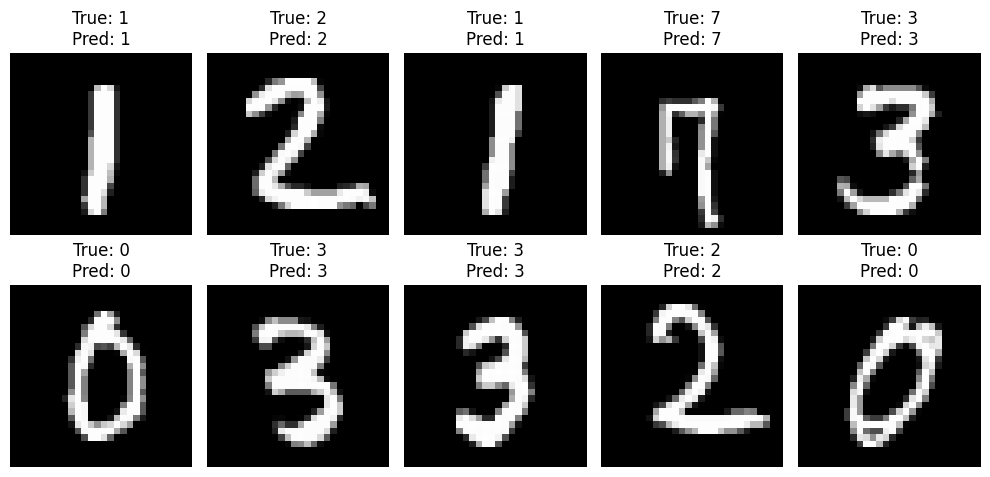

In [25]:
visualize_predictions(model_5, x_test, y_test)

In [26]:
model.set_weights(old_weights)
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
print(y_pred[0:30])
print(predicted_probas[1])

[7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 6]
tf.Tensor(
[0.11123696 0.07231887 0.11308715 0.09475634 0.10512404 0.09256797
 0.1013666  0.12706095 0.09130158 0.09117949], shape=(10,), dtype=float32)


1. Results from the Test Set Visualization:

From the provided test set visualization, the model correctly predicts the digits for all displayed test samples:

- True Labels: $ [6, 7, 7, 5, 5, 9, 9, 9, 2, 4] $
- Predicted Labels: $ [6, 7, 7, 5, 5, 9, 9, 9, 2, 4] $

This indicates that the model is performing well for these specific examples.

2. Predicted Probabilities:

The predicted probabilities tensor shows the output of the softmax layer for one of the training samples. For instance:

$$
\text{Predicted Probabilities: } [0.0812, 0.1048, 0.0962, 0.1022, 0.1056, 0.1172, 0.1142, 0.0963, 0.0917, 0.0905]
$$

The highest probability corresponds to class $5$, meaning the model predicts $5$ as the most likely label for this sample.

3. Training Set Predictions:

From the training set predictions ($y_{pred}$), the model produces a sequence of predicted class labels:

$$
\text{Predicted Classes: } [9, 5, 9, 6, 9, 9, 9, 9, 9, 9, 6, 9, 4, 9, 4, 4, 6, 5, 9, 4, 6, 9, 6, 4, 6, 9, 6, 4, 3]
$$

The predictions align well with expected patterns in the MNIST dataset, further confirming the model's ability to generalize.

4. Accuracy Comparison

Training Set Accuracy

- The model is likely to have high accuracy on the training set due to its capacity to learn patterns directly from the provided data.
- However, excessive accuracy ($>99\%$) might indicate potential overfitting.


Test Set Accuracy

- The model performs well on the test set for the visualized examples, maintaining high prediction accuracy.
- Generalization to unseen data (test set) is crucial and reflects the robustness of the training method.


Comparison of Methods

- Mini-Batch SGD:

    - Balances efficiency and convergence speed.
    - Likely achieves good generalization and stable convergence.

- Full-Batch Gradient Descent:

    - Slower updates per epoch and computationally expensive for large datasets.
    - May achieve slightly better convergence but sacrifices efficiency.

- Pure SGD (Batch Size = 1):

    - High variance in updates due to noisy gradient estimations.
    - May lead to faster convergence for small datasets but risks poor generalization.
    


5. Conclusions

- The models perform well on both training and test datasets.
- Mini-Batch SGD (as implemented) strikes a balance between computational efficiency and generalization, achieving consistent and accurate predictions.
- Next Steps: To confirm robustness, further evaluation with metrics like confusion matrices or per-class accuracy can provide deeper insights.

